실습 하기에 앞서 파이토치 2.x설치

In [13]:
import torch
print(torch.__version__)

2.0.1+cu118


## 1. 랜덤으로 만든 시계열 데이터 연습(Many-to-one)

RNN은 일반적으로 시간 순서가 정해진 일명, 시계열 데이터를 분석하기에 적합한 인공신경망입니다.  
데이터 간에 순서에 따라 의미가 달라진다면, 데이터를 순서에 맞춰 학습시키는 것이 효과적일 것입니다.  
Recurrent Neural Networks가 바로 이에 적합한 구조입니다.

### 1-1 단층 Simple RNN으로 데이터 실습

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.auto import tqdm

In [2]:
from sklearn.model_selection import train_test_split

RNN은 입력 sequence의 길이와 출력 sequence의 길이에 따라, Many-to-one, Many-to-Many, one-to-Many 등이 있습니다.


학습하는 방식은 크게 다르지 않습니다.  
먼저, Many-to-one 예제 데이터를 직접 생성하여 실습을 진행해보겠습니다.

np.sin함수와 np.arange함수, np.random.random함수를 사용해 랜덤한 파형 그래프를 그리는 데이터를 생성하겠습니다.

In [ ]:
data = np.sin(2*np.pi*np.arange(0, 1000))*10 + np.random.random(1000)
data.shape

(1000,)

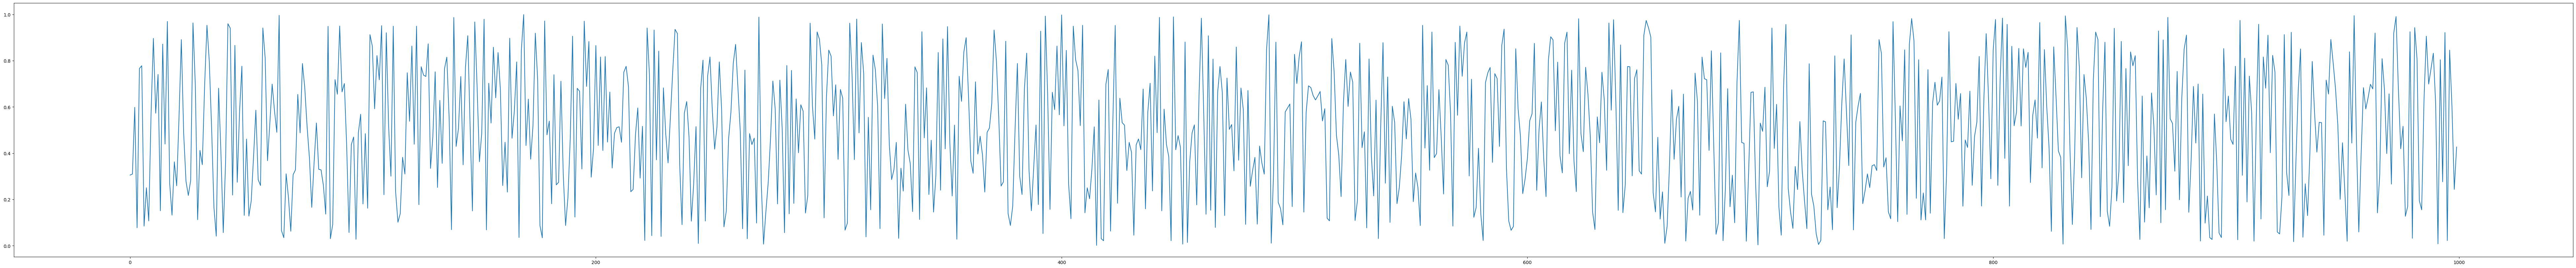

In [ ]:
plt.figure(figsize=[100, 10])
plt.plot(np.arange(0, 1000), data)
plt.show()

다음으로, 해당 샘플 데이터를 1칸씩 이동하며 10개씩 데이터를 잘라, x값으로 사용하고, y값은 11번째 데이터로 사용하겠습니다.
예) x = 1번째 ~ 10번째 데이터 / y = 11번째

질문) 길이가 100인 data를 이용해, 몇 쌍의 x, y 데이터를 만들어낼 수 있을까요?


In [ ]:
x_sin = np.array([[[data[i+j]] for j in range(10)] for i in range(len(data)-9-1)])
y_sin = np.array([[data[i+10]] for i in range(len(data)-10)])
x_sin.shape, y_sin.shape

((990, 10, 1), (990, 1))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_sin, y_sin, shuffle=False) # shuffle = False로 명시하면, 데이터셋 순차적으로 split

In [ ]:
x_train.shape, type(y_train)

((742, 10, 1), numpy.ndarray)

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)

    def __getitem__(self, index):
        # x = torch.from_numpy(self.x[index]).float()
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)  # self.x.shape[0]

In [ ]:
train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

RNN은 모델은 크게 SimpleRNN, LSTM, GRU 모델이 있습니다.

가장 기본이 되는 SimpleRNN부터 살펴보겠습니다.  
RNN layer를 사용할 때 주요 parameter는 두 가지입니다.  
1) input_size = input 데이터의 feature 개수로 여기서는 1입니다.  
2) hidden_size = hidden_layer(Memory Cell)의 node 개수입니다.  
3) batch_first = batch_size를 0번째 위치로 오게 합니다. (output에만 영향)  
4) num_layers = 다층 RNN을 구현 시 층 개수입니다.

In [ ]:
y_train.max(), y_train.min()

(0.9994424153719698, 0.001611710813528463)

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=8, batch_first=True)
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        self.rnn.flatten_parameters()
        # x -> (batch_size, sequence_length, input_dim)     (16, 10, 1)
        output, hidden = self.rnn(x)
        # output = [batch_size, seq_len, hidden_dim]        (16, 10, 8)
        # hidden = [num_layers, batch_size, hidden_dim]     (1, 16, 8)

        output = self.fc(hidden[-1])
        return output

In [ ]:
nn.RNN?

In [ ]:
model = SimpleRNN()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()     # 회귀모델이므로 MeanSquareLoss 이용
optimizer = optim.Adam(model.parameters())
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [ ]:
import torchsummary
# summary에서만 2개 (실제는 1개이다.)
torchsummary.summary(model.cuda(), (10, 1))

RuntimeError: ignored

In [ ]:
epochs = 5

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input_dim     (16, 10, 1)
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    # scheduler.step()

In [ ]:
# 테스트 값 예측
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu().squeeze(1)
        y_pred = torch.cat((y_pred, output))    # concat
        y_real = torch.cat((y_real, label))

In [ ]:
y_pred.shape, y_real.shape

In [ ]:
y_train.shape

In [ ]:
y_axis = np.arange(0, len(y_train))     # 0 ~ 741
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))  # 742 ~ 989 (742+248-1)

plt.figure(figsize=(100,10))
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o') # Train데이터 그래프로 표현
plt.plot(y_2_axis, y_pred.reshape(len(y_real),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_real.reshape(len(y_real),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()

### 1-2 다층 SimpleRNN 실습

이번엔 SimpleRNN layer를 추가해봅시다.  
핵심 개념은 layer의 깊이와 Sequence의 길이를 헷갈리지 않는 것입니다.  
위에서 살펴본 단층 SimpleRNN은 layer의 깊이는 1이고, Sequence의 길이가 10입니다.  
이번에는 SimpleRNN의 layer의 깊이를 3으로 높여봅시다.

CNN처럼 RNN도 층을 쌓을 수 있습니다.  
모델의 output이 어떻게 나오는지를 잘 확인하고  
층을 쌓아야 문제없이 돌아갑니다.

In [ ]:
class MultiLayerSimpleRNN(nn.Module):
    def __init__(self):
        super(MultiLayerSimpleRNN, self).__init__()
        self.rnn1 = nn.RNN(input_size=1, hidden_size=8, num_layers=2, batch_first=True) # Layer 2
        self.rnn2 = nn.RNN(input_size=8, hidden_size=4, batch_first=True) # Layer 1
        self.fc = nn.Sequential(nn.Linear(4, 1), nn.Sigmoid())

    def forward(self, x):
        self.rnn1.flatten_parameters()
        self.rnn2.flatten_parameters()
        h0 = torch.zeros(2, x.size()[0], 8).to(device) # 초기 hidden state 설정 (num_layer, batch_size, hidden_dim)
        # num_layer가 2 이상일 때 hidden, _ -> hidden[-1]은 가장 마지막 output
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.rnn1(x, h0)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]

        h0 = torch.zeros(1, x.size()[0], 4).to(device) # 초기 hidden state 설정 (num_layer, batch_size, hidden_dim)
        output, hidden = self.rnn2(output, h0)
        print(output[:, -1, :])
        print(hidden[-1])
        output = self.fc(hidden[-1])
        return output

In [ ]:
model = MultiLayerSimpleRNN()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)


In [ ]:
torchsummary.summary(model.cuda(), (10, 1))

In [ ]:
epochs = 20

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    for data, label in tqdm(iter(test_loader)):
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            target = model(data)
        loss = criterion(target, label)
        val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    # scheduler.step()

In [ ]:
# 테스트 값 예측
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
y_pred.shape, y_real.shape

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(100,10))
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o') # Train데이터 그래프로 표현
plt.plot(y_2_axis, y_pred.reshape(len(y_real),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_real.reshape(len(y_real),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()

### 1-3 LSTM 실습

RNN의 Degradation 문제를 해결한 LSTM 모형을 구현해보겠습니다.

정작 코드로 구현하는 것은 단순합니다.
layer의 구조를 RNN에서 LSTM만 바꾸면 됩니다.

우선, 단층 LSTM을 구현해보자.

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(10, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        h0 = torch.zeros(1, x.size()[0], 10).to(device) # 초기 hidden state 설정    (단기 기억 단자)
        c0 = torch.zeros(1, x.size()[0], 10).to(device) # 초기 cell state 설정      (장기 기억 단자)
        # x -> (batch_size, sequence_length, input_dim)
        output, (hidden, cell) = self.lstm(x, ) # (h0, c0)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])
        return output

In [ ]:
model = SimpleLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
epochs = 20

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    # scheduler.step()

In [ ]:
# 테스트 값 예측
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(100,10))
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o') # Train데이터 그래프로 표현
plt.plot(y_2_axis, y_pred.reshape(len(y_real),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_real.reshape(len(y_real),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()

다층 LSTM도 MultiLayerSimpleRNN과 구현하는 방식은 동일하다.

In [ ]:
class MultiLayerSimpleLSTM(nn.Module):
    def __init__(self):
        super(MultiLayerSimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(10, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        h0 = torch.zeros(2, x.size()[0], 10).to(device) # 초기 hidden state 설정
        c0 = torch.zeros(2, x.size()[0], 10).to(device) # 초기 cell state 설정
        # x -> (batch_size, sequence_length, input_dim)
        output, (hidden, cell) = self.lstm(x, (h0, c0))
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])    # 마지막 layer의 마지막 hidden state을 output으로 활용  (앞의 데이터를 모두 고려하기 위해 마지막 hidden state를 활용)
        return output

In [ ]:
model = MultiLayerSimpleLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
epochs = 5

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
# 테스트 값 예측
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(100,10))
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o') # Train데이터 그래프로 표현
plt.plot(y_2_axis, y_pred.reshape(len(y_real),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_real.reshape(len(y_real),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()

### 1-4 GRU


이번엔 LSTM을 발전시킨 GRU 모형을 구현해보겠습니다.

In [ ]:
class SimpleGRU(nn.Module):
    def __init__(self):
        super(SimpleGRU, self).__init__()
        self.gru1 = nn.GRU(input_size=1, hidden_size=10, num_layers=1, batch_first=True)
        self.gru2 = nn.GRU(input_size=10, hidden_size=8, num_layers=1, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(8*10, 1),     # hidden_dim * sequence_len
            nn.Sigmoid()
        )

    def forward(self, x):
        h0 = torch.zeros(1, x.size()[0], 10).to(device) # 초기 hidden state 설정
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.gru1(x, h0)
        h0 = torch.zeros(1, x.size()[0], 8).to(device) # 초기 hidden state 설정
        output, hidden = self.gru2(output, h0)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]

        # output.reshape(-1, 80)
        # output = self.fc(hidden[-1])
        output = self.fc(output.reshape(-1, 80))
        return output

In [ ]:
model = SimpleGRU()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=3, gamma=0.7)


In [ ]:
epochs = 5

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
# 테스트 값 예측
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(100,10))
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o') # Train데이터 그래프로 표현
plt.plot(y_2_axis, y_pred.reshape(len(y_real),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_real.reshape(len(y_real),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()

### 1-4 양방향 LSTM

일반적인 RNN은 정방향으로 데이터를 처리합니다.  
정방향데이터로 추론하는게 아닌 역방향으로 통해 데이터를 추론 할경우 정방향 못지 않는 데이터를 추론할 수가 있습니다.  
그래서 양방향으로 데이터를 추론 할수 있께 해주는 것이 Bidirectional입니다.  
역방향데이터 추론은 텍스트데이터에 많이 이용하고 있습니다.

In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(self):
        super(BidirectionalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(10*2, 1),     # 양방향이기 때문에 2를 곱해준다.
            nn.Sigmoid()
        )

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim)
        output, (hidden, _) = self.lstm(x)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers*2, batch_size, hidden_dim]
        output = self.fc(hidden.reshape(x.shape[0], -1))    # batch_size, bidirectional(2) * hidden_dim(10)
        return output

In [ ]:
#model = BidirectionalLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
epochs = 5

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    # scheduler.step()

In [ ]:
# 테스트 값 예측
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(100,10))
plt.plot(y_axis, y_train.reshape(len(x_train),), '-o') # Train데이터 그래프로 표현
plt.plot(y_2_axis, y_pred.reshape(len(y_real),), '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis, y_real.reshape(len(y_real),), '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()

### 1-5 양방향 다층LSTM

이번에는 양방향모델과 다층모델을 이용하여 예측하는 모델입니다.

In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(self):
        super(BidirectionalLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=8, num_layers=1, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=8*2, hidden_size=4, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(4*2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim)
        output, (hidden, _) = self.lstm1(x)
        output, (hidden, _)= self.lstm2(output)
        # output = [batch_size, seq_len, hidden_dim * 2]
        # hidden = [num_layers*2, batch_size, hidden_dim]
        output = self.fc(hidden.reshape(x.shape[0], -1))
        return output

In [ ]:
model = BidirectionalLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
epochs = 5

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    # scheduler.step()

In [ ]:
# 테스트 값 예측
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
y_axis = np.arange(0, 70)
y_2_axis = np.arange(70, 90)

plt.figure(figsize=(15,10))
plt.plot(y_axis[:70], y_train[:70], '-o') # Train데이터 그래프로 표현
plt.plot(y_2_axis[:20], y_pred[:20], '-o', color='red', label='predicted') #x_test 예측값 그래프로 표현
plt.plot(y_2_axis[:20], y_real[:20], '-o', color='purple', alpha=0.3, label='actual') #y_test 실제값 그래프로 표현
plt.legend(fontsize=40)
plt.show()

In [ ]:
# Quiz.

# 랜덤으로 값을 생성

np.random.rand(10, 3) # -> 0~1

# 2000 ~ 2400 -> 20, 10, 5 / INT
(np.random.rand(20, 10, 5) * 2000 + 400).astype(np.int32)

# -26 ~ 36 -> 5, 3, 2 / INT
(np.random.rand(5, 3, 2) * 62 - 26).astype(np.int32)

In [ ]:
data = np.sin( np.pi * np.arange(0, 100)* 2.025 ) + np.random.random(100)
x = np.array([data[i+j] for i in range(len(data)-10) for j in range(10)])
x_train = x[:700].reshape(-1,10,1)
x_test = x[700:].reshape(-1,10,1)
y = np.array([data[i+10] for i in range(len(data)-10)])
y_train = y[:70].reshape(-1,1)
y_test = y[70:].reshape(-1,1)

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

### 1-7 Quiz1) 지워진 코드를 채워보자

LSTM 실습도중에 코랩이 팅겨 코드의 일부분이 지워져 버렸다.  
최종적으로 예측 데이터와 실제데이터 비교하는 그래프까지 출력을 해보자



In [ ]:
#### 문제 1 ####
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, batch_first=True) # LSTM을 사용하여 채워보자 !
        self.fc = nn.Linear(10, 1) # 필요하다면, linear의 input size를 변경해준다 !

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim) # lstm의 output은 어떻게 나오는지 채워보자 !
        output, (hidden, _) = self.lstm(x, )
        output = self.fc(hidden[-1])
        return output

################

model = SimpleLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=100, gamma=0.7)


In [ ]:
epochs = 500

for epoch in range(1, epochs+1):
    # 학습
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
#### 문제 2 ####
# 학습된 모델로 예측을 해보자

model.eval() # 모델 eval모드로 변경

y_pred = torch.Tensor([])
y_real = torch.Tensor([])
for data, label in test_loader:
    data, label = data.to(device), label
    # 학습된 가중치가 변경되지 않도록 변경
    with torch.no_grad():
        output = model(data).detach().cpu()
    y_pred = torch.cat((y_pred, output))
    y_real = torch.cat((y_real, label))
################

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(10, 6))
plt.plot(y_axis, y_train.reshape(70,), '-o')
plt.plot(y_2_axis, y_pred.reshape(20,), '-o', color='red', label='predicted')
plt.plot(y_2_axis, y_real.reshape(20,), '-o', color='purple', alpha=0.15, label='actual')
plt.legend()
plt.show()

#### Answer)

In [ ]:
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(15,10))
plt.plot(y_axis, y_train.reshape(70,), '-o')
plt.plot(y_2_axis, y_pred.reshape(20,), '-o', color='red', label='predicted')
plt.plot(y_2_axis, y_real.reshape(20,), '-o', color='purple', alpha=0.15, label='actual')
plt.legend()
plt.show()

# ------------------

In [ ]:
data = np.sin( np.pi * np.arange(0, 100)* 2.025 ) + np.random.random(100)

x = np.array([data[i+j] for i in range(len(data)-10) for j in range(10)])
x_train = x[:700].reshape(-1,10,1)  # input_size = 1
x_test = x[700:].reshape(-1,10,1)

y = np.array([data[i+10] for i in range(len(data)-10)])
y_train = y[:70].reshape(-1,1)
y_test = y[70:].reshape(-1,1)

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

### 1-8 Quiz2) 지워진 코드를 채워보자2

다층 RNN 실습 도중 정전이 발생하여 코드가 날라가는 일이 발생하였습니다.  
최종적으로 예측 데이터와 실제데이터 비교하는 그래프까지 출력을 해보자

In [ ]:

#### 문제 1 ####
class MyGRU(nn.Module):
    def __init__(self):
        super(MyGRU, self).__init__()
        # 모델 만들기 (GRU hidden_size=16, layer 2개)
        # GRU 한 층 더 쌓기 (input_size=?? hidden_size=4, layer 1개)
        self.gru1 = nn.GRU(input_size=1, hidden_size=16, num_layers=2, batch_first=True)
        self.gru2 = nn.GRU(input_size=16, hidden_size=4, num_layers=1, batch_first=True)
        # Linear layer 추가 -> input_dim, output_dim 어디서 확인? -> 이전 레이어 output, y값 dimension
        self.fc = nn.Linear(4, 1)

    def forward(self, x):
        # 모델에 x 데이터 넣기
        output, hidden = self.gru1(x)
        output, hidden = self.gru2(output)
        # h0 = torch.zeros(2, x.size()[0], 16).to(device) # 초기 hidden state 설정
        # output, hidden = self.gru1(x, h0)
        # h0 = torch.zeros(1, x.size()[0], 4).to(device) # 초기 hidden state 설정
        # output, hidden = self.gru2(output, h0)
        output = self.fc(hidden[-1])
        return output

model = MyGRU()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=100, gamma=0.7)


#### 문제 3 ####
# 모델 학습
epochs = 500

for epoch in range(1, epochs+1):

    model.train() # 모델을 학습(train)모드로 변경하자.
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        # 이전 학습 상태가 반영되지 않게 optimizer의 기울기(grad)를 0(zero)으로 초기화하자
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        # loss를 역전파해서 가중치를 업데이트하자
        loss.backward()

        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()
################

In [ ]:
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
for data, label in test_loader:
    data, label = data.to(device), label
    with torch.no_grad():
        output = model(data).detach().cpu()
    y_pred = torch.cat((y_pred, output))
    y_real = torch.cat((y_real, label))

# y_hat = model(x_test)
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

plt.figure(figsize=(15,10))
plt.plot(y_axis, y_train.reshape(70,), '-o')
plt.plot(y_2_axis, y_pred.reshape(20,), '-o', color='red', label='predicted')
plt.plot(y_2_axis, y_real.reshape(20,), '-o', color='purple', alpha=0.15, label='actual')
plt.legend()
plt.show()

#### Answer)

### 1-9 원달러 환율 예측

원달러 환율 900일 데이터를 가지고 확율 예측 모델을 만들겟습니다.

In [ ]:
import pandas as pd
Data = pd.read_excel('Dollor.xlsx')

In [ ]:
X = np.array(Data.iloc[:,1:])
X = (X-X.mean(axis=0))/X.std(axis=0) #정규화

900일동안 환율의 상태를 살펴보면 변동이 크게 있는 것을 알수가 있습니다.

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(len(X)),X)
plt.legend()
plt.show()

In [ ]:
# 데이터 분리
x = np.array([X[i+j] for i in range(len(X)-9) for j in range(10)]).reshape(-1,10,1)
y = np.array([X[i+10] for i in range(len(X)-10)]).reshape(-1,1)
x_split = int(x.shape[0]*0.7)
y_split = int(y.shape[0]*0.7)
x_train = x[:x_split]
x_test = x[x_split:-1,:,:]
y_train = y[:y_split]
y_test = y[y_split:]

In [ ]:
# 데이터셋 만들기
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)

    def __getitem__(self, index):
        # x = torch.from_numpy(self.x[index]).float()
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

train_dataset = CustomDataset(x_train, y_train)
test_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

#### Quiz) 원달러환율 데이터셋을 이용한 모델 작성

여태까지 실습했던 내용으로 모델을 구축해보고  
예측했던 데이터와 실제 데이터를 비교하는 그래프를 그려보자

학습데이터는 10일의 데이터를 가지고 다음날을 예측하면 됩니다.  
데이터의 70%는 학습데이터이고 30%는 테스트 데이터 셋입니다.  
사용하는 모델은 자유입니다.

In [ ]:
# 딥러닝 구축 모델 순서
# 1. 모델링 - 학습시킬 모델을 준비하는 단계
# 2. 컴파일 - 모델 학습에 쓰일 optimizer, loss, scheduler등을 설정하는 단계
# 3. 학습 - 모델 학습 단계
# 4. 테스트 - 모델 테스트 단계

In [ ]:
# 데이터 분석 프로젝트 절차
# 1. 분석 기획
# 2. 데이터 수집 -> 크롤링
# 3. 데이터 탐색 (EDA) 및 가공
# 4. 데이터 분석 (모델링, 시각화)
# 5. 결과물 정리, 모델 적용

##### Answer)

In [ ]:
# 1. 모델링 - GRU
class SimpleGRU(nn.Module):
    def __init__(self):
        super(SimpleGRU, self).__init__()
        self.gru1 = nn.GRU(input_size=1, hidden_size=10, num_layers=1, batch_first=True)
        self.gru2 = nn.GRU(input_size=10, hidden_size=8, num_layers=1, batch_first=True)
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        output, hidden = self.gru1(x)
        output, hidden = self.gru2(output)
        output = self.fc(hidden[-1])
        return output

In [ ]:
# 2. 컴파일
model = SimpleGRU()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.05)
scheduler = StepLR(optimizer, step_size=3, gamma=0.7)

In [ ]:
# 3. 학습
epochs = 5

for epoch in range(1, epochs+1):
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

    # 4. 테스트
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data, label in tqdm(iter(test_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
# 예측값과 실제 값 비교
y_axis = np.arange(0, len(y_train))
y_2_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(15,10))
plt.plot(y_2_axis, y_pred.reshape(y_pred.shape[0],), '-o', color='red', label='predicted')
plt.plot(y_2_axis, y_real.reshape(y_real.shape[0],), '-o', color='purple', alpha=0.15, label='actual')
plt.legend()
plt.show()

## 2. 제나기후(단일 항목)


독일에 있는 예나(제나) 도시를 막스 플랑크 생물지구화학 연구소의 지상 관측소에서 수년간 수집한 데이터로써 약 57만개의 데이터셋입니다.


In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip #데이터셋 다운로드

In [ ]:
!unzip jena_climate_2009_2016.csv.zip #데이터셋 압축풀기

In [ ]:
import pandas as pd
Data = pd.read_csv('jena_climate_2009_2016.csv') #데이터셋 불러오기
del Data['Date Time'] # 시간행 삭제

In [ ]:
Data


예나 데이터셋은 GRU모델로 시작해보겠습니다.  
규제화를 주지 않고 GRU 모델만 사용해보겠습니다.

정규화는 20만개 데이터로 진행을 하겠고,  
학습데이터는 만개 정도로만 할 예정입니다.  
데이터가 많아지면 학습시간이 길어지기 때문에 일부분만 갖고 하겠습니다.  
또한 항목은 14가지 정도 있지만 저희는 온도로만 작성하는 걸로 하겠습니다.


In [ ]:
import numpy as np
float_data = np.array(Data)
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std
X = float_data[:10000,:1]
x_train = np.array([X[i+j] for i in range(len(X)-10) for j in range(10)]).reshape(-1,10,1)
y_train = np.array([X[i+10]for i in range(len(X)-10)])

In [ ]:
x_train.shape

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(range(len(x_train[:1000])), y_train[:1000], 'o-',color='red')
# plt.plot(range(1430), y_pred, 'o')
plt.legend()

plt.show()

### 2-1 제나기후 GRU모델

이번 코드에서는 Dropout이라는 속성이 추가가 되었습니다.  
Dropout과 Recurrent_dropout이 추가 되었습니다.  
뜻이 탈락과 같은 형태로 쓰이고 있습니다.  
0~1 사이에 실수의 값을 주고 그 %로 만큼의 데이터를 버리게 되는 것입니다.  
Recurrent_dropout은 Dropout과 별차이가 없으며 순환적인 데이터를 버리는 것입니다.


In [ ]:
class DropoutGRU(nn.Module):
    def __init__(self):
        super(DropoutGRU, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=32, num_layers=1, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size()[0], 32).to(device) # 초기 hidden state 설정
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.gru(x, h0)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])
        return output

model = DropoutGRU()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.L1Loss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)


In [ ]:
# 데이터셋 만들기
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)

    def __getitem__(self, index):
        # x = torch.from_numpy(self.x[index]).float()
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, shuffle=True) # shuffle = False로 명시하면, 데이터셋 순차적으로 split

train_dataset = CustomDataset(x_train, y_train)
valid_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=40, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=40)

In [ ]:
# 모델 학습시키기
epochs = 50

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    for data, label in tqdm(iter(valid_loader)):
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            target = model(data)
        loss = criterion(target, label)
        val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

Loss 그래프를 살펴봤을 때 과적합은 발생하지 않는 것을 알수가 있습니다.

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
X = float_data[50000:51440,:1]
x_test = np.array([X[i+j] for i in range(len(X)-10) for j in range(10)]).reshape(-1,10,1)
y_test = np.array([X[i+10]for i in range(len(X)-10)])

test_dataset = CustomDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1430), y_test, 'o-',color='red')
plt.plot(range(1430), y_pred, 'o')
plt.legend()

plt.show()

### 2-2 제나기후 SimpleRNN모델

이번에는 GRU모델이 아닌 SimpleRNN모델을 사용했을 때 보겠습니다.

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, dropout=0.2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 1),
            # nn.Sigmoid()
        )

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.rnn(x)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])
        return output

model = SimpleRNN()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.L1Loss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)


In [ ]:
# 모델 학습시키기
epochs = 50

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    for data, label in tqdm(iter(valid_loader)):
        data, label = data.to(device), label.to(device)
        with torch.no_grad():
            target = model(data)
        loss = criterion(target, label)
        val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1430), y_real, 'o-',color='red',label='Actual')
plt.plot(range(1430), y_pred, 'o',label='Predicted')
plt.legend()

plt.show()

### 2-3 제나기후 LSTM모델

이번에는 LSTM 모델로 학습시킨 것을 보겠습니다

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, dropout=0.35, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim)
        output, (hidden, cell) = self.lstm(x)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])
        return output

model = SimpleLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
# 모델 학습시키기
epochs = 50

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(iter(valid_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

그래프를 보면 vaildation이 올라가는 것을 볼 수 있고,
training_loss가 Vaildation보다 높은 것을 봤을 때 좋은 결과가 아닌 것을 확인 할 수 있습니다

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1430), y_real, 'o-',color='red',label='Actual')
plt.plot(range(1430), y_pred, 'o',label='Predicted')
plt.legend()

plt.show()

### 2-4 제나기후 다층모델

단층이 아닌 다층모델로 구현했을 때 모습을 보겠습니다

In [ ]:
class MultiLayerGRU(nn.Module):
    def __init__(self):
        super(MultiLayerGRU, self).__init__()
        self.gru1 = nn.GRU(input_size=1, hidden_size=32, num_layers=2, dropout=0.2, batch_first=True)
        self.gru2 = nn.GRU(input_size=32, hidden_size=16, num_layers=1, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.gru1(x)
        output, hidden = self.gru2(output)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])
        return output

model = MultiLayerGRU()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
# 모델 학습시키기
epochs = 50

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(iter(valid_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

다층을 구현하더라도 성능이 확 좋아지는 것을 확인 할 수는 없는 것 같습니다

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1430), y_real, 'o-',color='red',label='Actual')
plt.plot(range(1430), y_pred, 'o',label='Predicted')
plt.legend()

plt.show()

### 2-5 제나기후 GRU 양방향모델

양방향 모델입니다

In [ ]:
class BidirectionalMultiLayerGRU(nn.Module):
    def __init__(self):
        super(BidirectionalMultiLayerGRU, self).__init__()
        self.gru1 = nn.GRU(input_size=1, hidden_size=32, num_layers=2, dropout=0.2, bidirectional=True, batch_first=True)
        self.gru2 = nn.GRU(input_size=64, hidden_size=16, num_layers=1, dropout=0.2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(16, 1)

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.gru1(x)
        output, hidden = self.gru2(output)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden.reshape(x.shape[0], -1))
        return output

model = BidirectionalMultiLayerGRU()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
# 모델 학습시키기
epochs = 50

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(iter(valid_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1430), y_real, 'o-',color='red',label='Actual')
plt.plot(range(1430), y_pred, 'o',label='Predicted')
plt.legend()

plt.show()

### 2-6 Quiz) 제나기후 문제

지워진 코드를 채워보자
LSTM층은 단층이며 28번의 Unit이 있고, 35%정도 데이터는 규제를 할 것입니다.
loss 그래프를 보고 과적합이 나는지를 확인하시오

In [ ]:
#### 문제 1 ####
class DropoutLSTM(nn.Module):
    def __init__(self):
        super(DropoutLSTM, self).__init__()
        self.lstm = # LSTM
        self.fc = # Linear

    def forward(self, x):
        output, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return output

################

model = DropoutLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

#### 문제 2 ####
# loss 함수 작성
criterion =

# optimizer 작성
optimizer =

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
################

# 모델 학습시키기
epochs = 50

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(iter(valid_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Answer)

### 2-7 Quiz) 제나기후 모델 만들기

이번에는 GRU 모델을 사용하여 다층모델을 만드려고 합니다.  
optimizer는 adam이 아닌 다른 모델을 사용해야 합니다.  
Loss 그래프만이 아닌 예측 그래프도 그려서 같이 볼려고 합니다.  
규제화는 50%로 줄것이며, 최소 3층이상인 다층 모델입니다.  
테스트 데이터는 2만번 째 데이터부터 사용할 것이며 20일 데이터를 예측 할 것입니다.  
(10분 마다 기록하기에 한시간에는 6개의 데이터생성 6*24 = 144 하루 데이터 양)

#### Answer)

## 3. 제나기후(14개 항목)





이번에는 14개의 항목을 넣고 학습을 시켜보겠습니다.
단일 모델과 코드는 같습니다

In [ ]:
import numpy as np
float_data = np.array(Data)
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

X = float_data[:10000]
x_train=X[:9856].reshape(-1,14,1)
y_train=X[144:,:1]

In [ ]:
# 데이터셋 만들기
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)

    def __getitem__(self, index):
        # x = torch.from_numpy(self.x[index]).float()
        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, shuffle=True) # shuffle = False로 명시하면, 데이터셋 순차적으로 split

train_dataset = CustomDataset(x_train, y_train)
valid_dataset = CustomDataset(x_test, y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

In [ ]:
x_test = float_data[50000:51440].reshape(-1,14,1)
y_test = float_data[50144:51584,:1]

test_dataset = CustomDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

### 3-1 제나기후 GRU 모델

In [ ]:
class DropoutGRU(nn.Module):
    def __init__(self):
        super(DropoutGRU, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=32, num_layers=1, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size()[0], 32).to(device) # 초기 hidden state 설정
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.gru(x, h0)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])
        return output

model = DropoutGRU()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
# 모델 학습시키기
epochs = 20

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(iter(valid_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1440), y_real, 'o-',color='red',label='Actual')
plt.plot(range(1440), y_pred, 'o',label='Predicted')
plt.legend()

plt.show()

### 3-2 제나기후 SimpleRNN 모델

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.rnn(x)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])
        return output

model = SimpleRNN()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
# 모델 학습시키기
epochs = 20

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(iter(valid_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1440), y_real, 'o-',color='red',label='Actual')
plt.plot(range(1440), y_pred, 'o',label='Predicted')
plt.legend()

plt.show()

### 3-3 제나기후 LSTM 모델

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.gru = nn.LSTM(input_size=1, hidden_size=32, num_layers=1, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        # x -> (batch_size, sequence_length, input_dim)
        output, (hidden, cell) = self.gru(x)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        output = self.fc(hidden[-1])
        return output

model = SimpleLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
# 모델 학습시키기
epochs = 20

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(iter(valid_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1440), y_real, 'o-',color='red',label='Actual')
plt.plot(range(1440), y_pred, 'o',label='Predicted')
plt.legend()

plt.show()

### 3-4 제나기후 GRU 드랍아웃 0.5

In [ ]:
class DropoutGRU(nn.Module):
    def __init__(self):
        super(DropoutGRU, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=32, num_layers=1, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size()[0], 32).to(device) # 초기 hidden state 설정
        # x -> (batch_size, sequence_length, input_dim)
        output, hidden = self.gru(x, h0)
        # output = [batch_size, seq_len, hidden_dim]
        # hidden = [num_layers, batch_size, hidden_dim]
        hidden = torch.tanh(hidden[-1])
        output = self.fc(hidden)
        return output

model = DropoutGRU()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)


In [ ]:
# 모델 학습시키기
epochs = 20

history = {
    'loss': [],
    'val_loss': []
}
for epoch in range(1, epochs+1):
    train_loss = []
    val_loss = []

    # 학습
    model.train()
    for batch_idx, (data, label) in enumerate(tqdm(iter(train_loader))):
        data, label = data.to(device), label.to(device) # batch, seq, input
        optimizer.zero_grad()

        target = model(data)
        loss = criterion(target, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)
    history['loss'].append(_train_loss)

    # 테스트
    model.eval()
    with torch.no_grad():
        for data, label in tqdm(iter(valid_loader)):
            data, label = data.to(device), label.to(device)
            target = model(data)
            loss = criterion(target, label)
            val_loss.append(loss.item())

    _val_loss = np.mean(val_loss)
    history['val_loss'].append(_val_loss)

    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}]')

    scheduler.step()

In [ ]:
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'b', color='red',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# 예측값 뽑기
model.eval()
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label
        output = model(data).detach().cpu()
        y_pred = torch.cat((y_pred, output))
        y_real = torch.cat((y_real, label))

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(range(1440), y_real, 'o-',color='red',label='Actual')
plt.plot(range(1440), y_pred, 'o',label='Predicted')
plt.legend()

plt.show()

In [3]:
%pip install -U finance-datareader

In [4]:
import FinanceDataReader as fdr

fdr.StockListing('krx')
df = fdr.DataReader('005930', '2017-01-01', '2020-12-31')

In [23]:
raw_data = (df['Close'] - df['Close'].mean()) / df['Close'].std()

In [24]:
X = raw_data.to_numpy()

In [25]:
# 1. 데이터 가공 (input sequence 얼만큼?)
X_data = np.array([[X[i+j] for j in range(5)] for i in range(len(X) - 6)])    # 5일씩 잘라서 입력으로 사용
y_data = np.array([X[i+5] for i in range(len(X) - 6)])    # 5일 뒤 값을 y (target)

train_idx = int(len(X_data) * 0.7)  # 70% 데이터까지의 인덱스

X_train = X_data[:train_idx]
y_train = y_data[:train_idx]
X_test = X_data[train_idx:]
y_test = y_data[train_idx:]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(682, 5) (293, 5)
(682,) (293,)


In [26]:
# 2. 데이터셋, 데이터로더 정의

from torch.utils.data import Dataset, DataLoader

class CustomerDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x.reshape(-1, 5, 1))
        self.y = torch.Tensor(y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

train_dataset = CustomerDataset(X_train, y_train)
test_dataset = CustomerDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32)

In [27]:
class StockLSTM(nn.Module):
    def __init__(self):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, batch_first=True)
        self.fc = nn.Linear(10, 1)

    def forward(self, x):
        output, (hidden, _) = self.lstm(x, )
        output = self.fc(hidden[-1])
        return output

In [28]:
import torch.optim as optim
model = StockLSTM()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.5)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [29]:
epochs = 50

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    _train_loss = np.mean(train_loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [30]:
y_pred = torch.Tensor([])
y_real = torch.Tensor([])
for data, label in test_loader:
    with torch.no_grad():
        output = model(data)
        y_pred = torch.cat([y_pred, output])
        y_real = torch.cat([y_real, label])

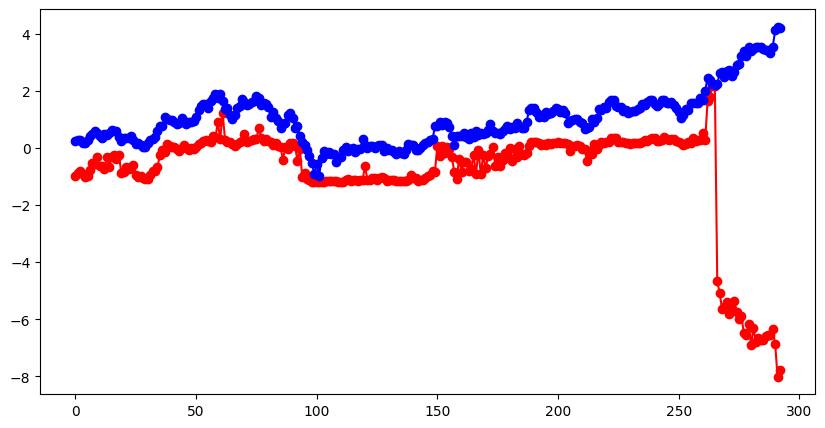

In [31]:
import matplotlib.pyplot as plt

x_axis = np.arange(0, len(y_pred))

plt.figure(figsize=(10, 5))

plt.plot(x_axis, y_pred, '-o', c="red")
plt.plot(x_axis, y_real, '-o', c="blue")
plt.show()